In [1]:
import estraces
import numpy as np
# from tqdm import trange
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# AES SBox
sbox = np.array([
    # 0     1    2    3    4    5    6    7    8    9    A    B    C    D    E    F
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
], dtype=np.uint8)


In [53]:
path_fixed1 = "./traces/traces_set_fixKey1_fixPlain1.ets"
path_random1 = "./traces/traces_set_fixKey1_RndPlain.ets"

ths_fixed1 = estraces.read_ths_from_ets_file(path_fixed1)
ths_random1 = estraces.read_ths_from_ets_file(path_random1)

In [54]:
nb_traces = 100
ths_0=ths_fixed1[:nb_traces]
ths_1=ths_random1[:nb_traces]
# Extraire les traces et les textes en clair
traces = np.array([t.samples for t in ths_1])
plaintexts = np.array([t.plaintext for t in ths_1])
true_key = ths_1[0].key

In [ ]:
def dpa_attack(traces, plaintexts, sbox):
    num_traces, trace_len = traces.shape
    dpa_scores = np.zeros((256, trace_len))

    for key_guess in range(256):
        bit_groups = [[], []]
        for i in range(num_traces):
            pt = plaintexts[i] if isinstance(plaintexts[i], (int, np.integer)) else plaintexts[i][0]
            sbox_out = sbox[pt ^ key_guess]
            bit = (sbox_out >> 7) & 1
            bit_groups[bit].append(traces[i])

        group0 = np.array(bit_groups[0])
        group1 = np.array(bit_groups[1])
        if group0.size > 0 and group1.size > 0:
            mean0 = np.mean(group0, axis=0)
            mean1 = np.mean(group1, axis=0)
            dpa_scores[key_guess] = np.abs(mean0 - mean1)

    return dpa_scores



In [47]:
# Lancer l'attaque DPA
dpa_scores = dpa_attack(traces, plaintexts, sbox)

In [48]:
score_moyens = dpa_scores.max(axis=1)

key_guess = np.argmax(score_moyens)
print(f"Clé estimée par DPA : {key_guess} (0x{key_guess:02x})")

Clé estimée par DPA : 86 (0x56)


In [56]:
ths_0[0]

Trace:
Reader instance..: ETS format reader of file ./traces/traces_set_fixKey1_fixPlain1.ets with 100 traces.
Index in set.....: 0
Samples size.....: 5000
ciphertext.......: [ 13 218  36  20  25 130  49  57  23 138 199   5  70 220 193 227]
key..............: [ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
plaintext........: [177 125 235 138 105 240 253  31 221 216 134 242 182 101 223 123]

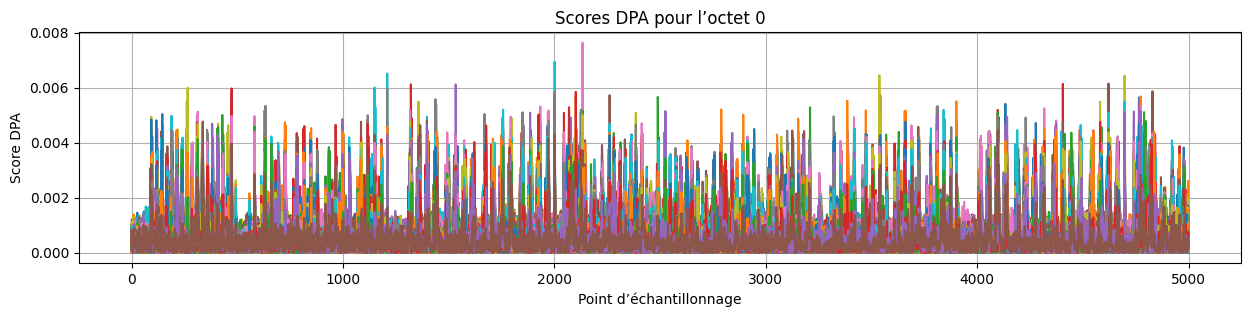

In [51]:
# Visualiser les résultats
plt.figure(figsize=(15, 3))
plt.plot(dpa_scores.T)
plt.title("Scores DPA pour l’octet 0")
plt.xlabel("Point d’échantillonnage")
plt.ylabel("Score DPA")
plt.grid(True)
plt.show()

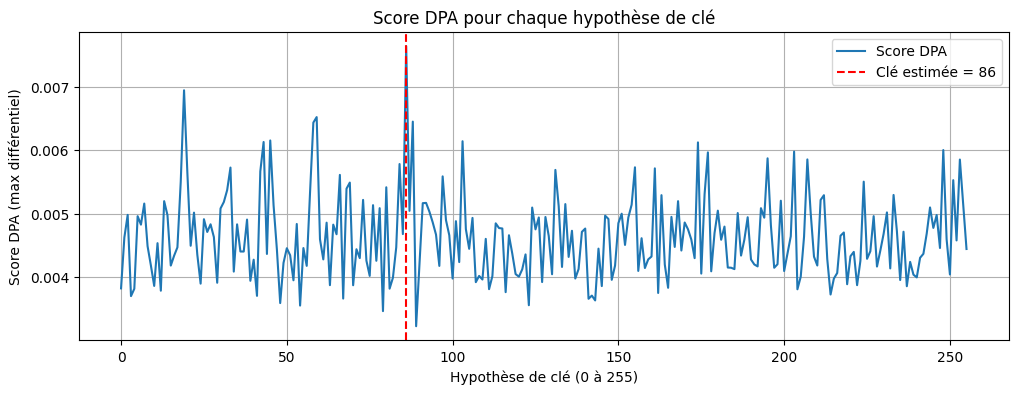

In [50]:
plt.figure(figsize=(12, 4))
plt.plot(score_moyens, label='Score DPA')
plt.axvline(key_guess, color='red', linestyle='--', label=f'Clé estimée = {key_guess}')
plt.title("Score DPA pour chaque hypothèse de clé")
plt.xlabel("Hypothèse de clé (0 à 255)")
plt.ylabel("Score DPA (max différentiel)")
plt.legend()
plt.grid(True)
plt.show()


In [44]:
def dpa_attack_byte(traces, plaintexts, sbox, byte_index):
    num_traces, trace_len = traces.shape
    dpa_scores = np.zeros((256, trace_len))

    for key_guess in range(256):
        bit_groups = [[], []]
        for i in range(num_traces):
            pt = plaintexts[i][byte_index]
            sbox_out = sbox[pt ^ key_guess]
            bit = (sbox_out >> 7) & 1
            bit_groups[bit].append(traces[i])

        group0 = np.array(bit_groups[0])
        group1 = np.array(bit_groups[1])
        if group0.size > 0 and group1.size > 0:
            mean0 = np.mean(group0, axis=0)
            mean1 = np.mean(group1, axis=0)
            dpa_scores[key_guess] = np.abs(mean0 - mean1)

    return dpa_scores


100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


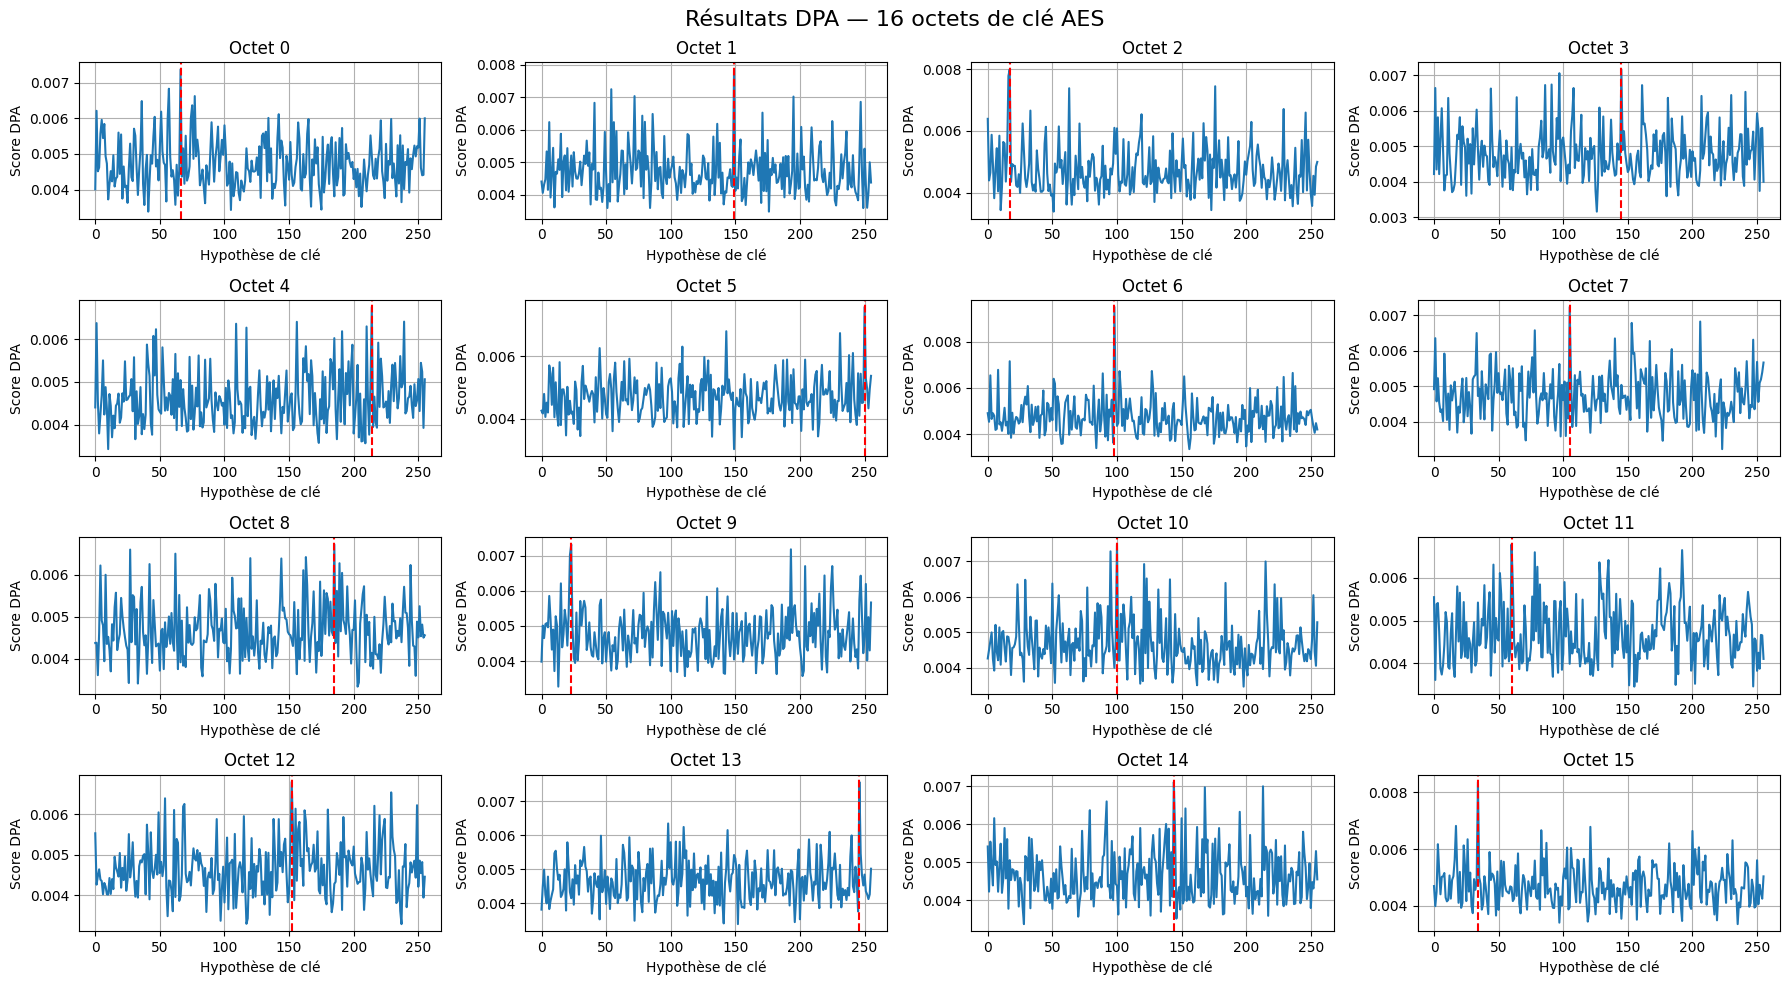

Clé estimée par DPA (hex) :
42 95 11 91 D6 FA 62 69 B9 17 64 3C 98 F6 90 22


In [52]:
guessed_key = []
fig, axs = plt.subplots(4, 4, figsize=(18, 10))
fig.suptitle("Résultats DPA — 16 octets de clé AES", fontsize=16)

for byte_index in tqdm(range(16)):
    scores = dpa_attack_byte(traces, plaintexts, sbox, byte_index)
    max_scores = scores.max(axis=1)
    key_byte = np.argmax(max_scores)
    guessed_key.append(key_byte)

    ax = axs[byte_index // 4][byte_index % 4]
    ax.plot(max_scores, label='Score DPA')
    ax.axvline(key_byte, color='red', linestyle='--', label=f'Deviné = {key_byte}')
    ax.set_title(f'Octet {byte_index}')
    ax.set_xlabel("Hypothèse de clé")
    ax.set_ylabel("Score DPA")
    ax.grid(True)

plt.tight_layout()
plt.show()

print("Clé estimée par DPA (hex) :")
print(" ".join(f"{k:02X}" for k in guessed_key))
